#### YOLO model <br>
Here an explanation of how YOLO works by DeepLearningAI: https://www.youtube.com/watch?v=9s_FpMpdYW8.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Yolo/

/content/drive/MyDrive/Yolo


In [3]:
# import the necessary packages
import numpy as np
import time
import cv2
import os
from google.colab.patches import cv2_imshow

Here we load all of our class LABELS. Random COLORS  are then assigned to each label.

In [4]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.join("coco.names")
LABELS = open(labelsPath).read().strip().split("\n")

In [5]:
len(LABELS)

80

In [6]:
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

Let’s derive the paths to the YOLO weights and configuration files followed by loading YOLO from disk:

To load YOLO from disk, we’ll take advantage of OpenCV’s DNN function called cv2.dnn.readNetFromDarknet . This function requires both a configPath  and weightsPath which are established.


In [7]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.join("yolov3.weights")
configPath = os.path.join("yolov3.cfg")

I cannot stress this enough: you’ll need at least OpenCV 3.4.2 to run this code as it has the updated dnn  module required to load YOLO.

Let’s load the image and send it through the network.

In [8]:
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


Load the input image  and extract its dimensions


In [9]:
# load our input image and grab its spatial dimensions
image = cv2.imread("dining_table.jpg")
(H, W) = image.shape[:2]

Determine the output layer names from the YOLO model

In [10]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In this block we:

Load the input image  and extract its dimensions.
Determine the output layer names from the YOLO model.
Construct a blob  from the image. Are you confused about what a blob is or what the cv2.dnn.blobFromImage  does? Give this blog post a read.
Now that our blob is prepared, we’ll

Perform a forward pass through our YOLO network.<br>
https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/

In [11]:
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

In [12]:
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 2.294547 seconds


What good is object detection unless we visualize our results? Let’s take steps now to filter and visualize our results.

But first, let’s initialize some lists we’ll need in the process of doing so.

These lists include:

boxes : Our bounding boxes around the object.

confidences : The confidence value that YOLO assigns to an object. Lower confidence values indicate that the object might not be what the network thinks it is. Remember from our command line arguments above that we’ll filter out objects that don’t meet the 0.5  threshold.

classIDs : The detected object’s class label.


In [13]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

Let’s begin populating these lists with data from our YOLO layerOutputs. 

There’s a lot here in this code block — let’s break it down.

In this block, we:

- Loop over each of the layerOutputs.

- Loop over each detection  in output  (a nested loop beginning).

- Extract the classID  and confidence.

- Use the confidence to filter out weak detections.


Now that we’ve filtered out unwanted detections, we’re going to:

- Scale bounding box coordinates so we can display them properly on our original image.

- Extract coordinates and dimensions of the bounding box. YOLO returns bounding box coordinates in the form: (centerX, centerY, width, and height) .

- Use this information to derive the top-left (x, y)-coordinates of the bounding box.

- Update the boxes , confidences , and classIDs  lists.<br> blog to understand Yolo output format<br>
https://towardsdatascience.com/yolo2-walkthrough-with-examples-e40452ca265f


In [14]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]  
		classID = np.argmax(scores)
		confidence = scores[classID]

		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.5:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")

			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))

			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

YOLO does not apply non-maxima suppression for us, so we need to explicitly apply it.

Applying non-maxima suppression suppresses significantly overlapping bounding boxes, keeping only the most confident ones.

NMS also ensures that we do not have any redundant or extraneous bounding boxes.

Taking advantage of OpenCV’s built-in DNN module implementation of NMS, we perform non-maxima suppression. All that is required is that we submit our bounding boxes , confidences , as well as both our confidence threshold and NMS threshold.

<br> None maximum suppression : <br> https://www.youtube.com/watch?v=VAo84c1hQX8

In [15]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

Assuming at least one detection exists, we proceed to loop over idxs  determined by non-maxima suppression.

Then, we simply draw the bounding box and text on image  using our random class colors.

Finally, we display our resulting image until the user presses any key on their keyboard (ensuring the window opened by OpenCV is selected and focused).

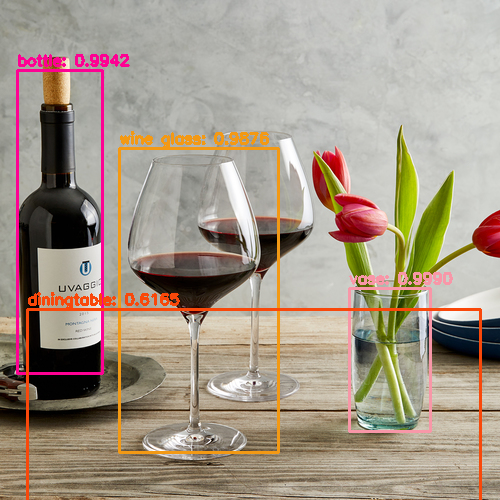

-1

In [16]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])

		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
			0.5, color, 2)

# show the output image
cv2_imshow(image)
cv2.waitKey(0)

While both the wine bottle, dining table, and vase are correctly detected by YOLO, only one of the two wine glasses is properly detected.